### 1. Import Dependencies

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics

### 2. Data preprocessing

In [120]:
# Change to full movies dataset
df = pd.read_csv('imdb_full_movies.csv')

In [121]:
df.head()

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide
0,Our Drawings,2023,TV-MA,1h 1m,1.2,"Paige Foster, discovers a mysterious intruder ...","Animation,Adventure",NaN,NaN,NaN
1,Clownfish,2010,NaN,1h 23m,1.2,A fish stuck in a fish pond does not have the ...,"Drama,Romance",NaN,NaN,NaN
2,Zaletchiki,2014,NaN,1h 24m,1.2,NaN,Comedy,NaN,NaN,NaN
3,American Fiction,2023,R,1h 57m,7.5,A novelist who's fed up with the establishment...,"Comedy,Drama","$21,098,470","$224,469","$22,483,370"
4,Manos: The Hands of Fate,1966,Not Rated,1h 10m,1.6,A family gets lost on the road and stumbles up...,Horror,"$19,000 (estimated)",NaN,NaN


In [122]:
df.describe()

,release_year,movie_rating
count,3840.000000,3840.000000
mean,2008.586979,4.790365
std,16.451029,2.140001
min,1917.000000,1.000000
25%,2001.000000,3.000000
50%,2014.000000,4.800000
75%,2021.000000,6.600000
max,2024.000000,9.300000


In [123]:
df.shape

(3840, 10)

In [124]:
# Examine duplicate entries
df[df.duplicated(subset='title', keep='first')]

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide
61,Who's Your Caddy?,2007,PG-13,1h 33m,2.3,When a rap mogul from Atlanta tries to join a ...,"Comedy,Sport","$7,000,000 (estimated)","$5,713,425","$5,713,425"
138,Baaghi 3,2020,Not Rated,2h 23m,2.2,A man embarks on a bloody rampage to save his ...,"Action,Adventure,Thriller","₹550,000,000 (estimated)","$721,439","$16,726,510"
157,Student of the Year 2,2019,Not Rated,2h 26m,2.2,A student must face off against bullies and ov...,"Action,Comedy,Drama","₹800,000,000 (estimated)","$778,566","$1,635,907"
170,365 Days,2020,TV-MA,1h 54m,3.3,Massimo is a member of the Sicilian Mafia fami...,"Drama,Romance","$9,458,590",NaN,NaN
176,Hobgoblins,1988,Not Rated,1h 28m,2.2,A young security guard must track down diminut...,"Comedy,Horror,Sci-Fi","$15,000 (estimated)",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3780,Stardust,2007,PG-13,2h 7m,7.6,In a countryside town bordering on a magical l...,"Adventure,Family,Fantasy","$70,000,000 (estimated)","$38,634,938","$137,515,140"
3803,Once Upon a Time... in Hollywood,2019,R,2h 41m,7.6,A faded television actor and his stunt double ...,"Comedy,Drama","$90,000,000 (estimated)","$142,502,728","$377,617,681"
3804,Killers of the Flower Moon,2023,R,3h 26m,7.6,When oil is discovered in 1920s Oklahoma under...,"Crime,Drama,History","$200,000,000 (estimated)","$68,026,901","$157,026,901"
3837,The Iron Claw,2023,R,2h 12m,7.7,The true story of the inseparable Von Erich br...,"Biography,Drama,Sport","$15,000,000 (estimated)","$35,070,296","$44,217,977"


In [125]:
# Remove duplicates
df.drop_duplicates(subset='title', keep='first', inplace=True)

In [126]:
# Check for null values
df.isnull().sum()

title                 0
release_year          0
parental_rating     747
movie_duration        2
movie_rating          0
description          50
genres                6
budget              945
gross_na           1632
gross_worldwide    1837
dtype: int64

In [127]:
df.dropna(subset = 'description', inplace=True)
df.dropna(subset = 'movie_duration', inplace=True)

In [128]:
df.isnull().sum()

title                 0
release_year          0
parental_rating     696
movie_duration        0
movie_rating          0
description           0
genres                2
budget              910
gross_na           1583
gross_worldwide    1786
dtype: int64

In [129]:
# Update indexes to correctly reflect the data
print(df.index)
df.reset_index(drop=True, inplace=True)

Index([   0,    1,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3838],
      dtype='int64', length=3531)


In [130]:
print(df.index)
df.shape

RangeIndex(start=0, stop=3531, step=1)


(3531, 10)

#### Process Numerical Data

In [134]:
df.movie_duration.unique()

array(['1h 1m', '1h 23m', '1h 57m', '1h 10m', '1h 25m', '2h 22m',
       '1h 13m', '1h 5m', '1h 30m', '1h 42m', '1h 24m', '1h 33m', '1h 3m',
       '1h 18m', '1h 14m', '1h 31m', '1h 20m', '1h 22m', '1h 35m',
       '1h 28m', '1h 19m', '1h', '1h 49m', '1h 21m', '1h 40m', '52m',
       '1h 45m', '1h 32m', '1h 12m', '1h 26m', '1h 41m', '1h 6m',
       '1h 50m', '1h 37m', '1h 34m', '2h 2m', '1h 36m', '1h 16m',
       '1h 11m', '45m', '2h 5m', '1h 47m', '1h 27m', '1h 15m', '1h 48m',
       '2h 26m', '3h 20m', '2h 23m', '1h 29m', '2h 7m', '2h 20m',
       '1h 39m', '1h 38m', '2h', '2h 15m', '2h 32m', '1h 44m', '2h 21m',
       '2h 59m', '1h 51m', '2h 1m', '2h 40m', '2h 17m', '58m', '1h 17m',
       '1h 43m', '2h 13m', '2h 30m', '1h 56m', '2h 6m', '1h 8m', '2h 10m',
       '2h 25m', '2h 4m', '1h 54m', '54m', '1h 2m', '2h 42m', '2h 18m',
       '1h 52m', '2h 12m', '1h 53m', '1h 4m', '2h 48m', '2h 39m',
       '5h 21m', '3h 1m', '2h 34m', '2h 9m', '2h 52m', '2h 28m', '1h 55m',
       '2h 3m', '

In [135]:
# Converts movie duration to minutes
def duration_to_min(duration):
    hours = 0
    minutes = 0
    
    if 'h' in duration:
        h_idx = duration.index('h')
        hours = int(duration[0:h_idx])
        if 'm' in duration:
            m_idx = duration.index('m')
            minutes = int(duration[duration.index(' ')+1:m_idx])
    elif 'm' in duration:
        minutes = int(duration.strip('m'))
    return hours * 60 + minutes

In [136]:
df.movie_duration = df.movie_duration.apply(duration_to_min)

In [137]:
df.movie_duration

0        61
1        83
2       117
3        70
4        85
       ... 
3526    108
3527    118
3528    114
3529    105
3530    163
Name: movie_duration, Length: 3531, dtype: int64

In [138]:
df.head()

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide
0,Our Drawings,2023,TV-MA,61,1.2,"Paige Foster, discovers a mysterious intruder ...","Animation,Adventure",NaN,NaN,NaN
1,Clownfish,2010,NaN,83,1.2,A fish stuck in a fish pond does not have the ...,"Drama,Romance",NaN,NaN,NaN
2,American Fiction,2023,R,117,7.5,A novelist who's fed up with the establishment...,"Comedy,Drama","$21,098,470","$224,469","$22,483,370"
3,Manos: The Hands of Fate,1966,Not Rated,70,1.6,A family gets lost on the road and stumbles up...,Horror,"$19,000 (estimated)",NaN,NaN
4,Kingdom of Gladiators,2011,Not Rated,85,1.7,A king makes a pact with an ancient demon and ...,"Action,Adventure,Fantasy","$3,000,000 (estimated)",NaN,NaN


#### Process Textual Data

In [139]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelleung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [140]:
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [141]:
# Stemming words
port_stem = PorterStemmer()

In [142]:
def to_stem(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', str(content))
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [143]:
df['description'] = df['description'].apply(to_stem)

In [144]:
df['description']

0       paig foster discov mysteri intrud insid artwor...
1       fish stuck fish pond luxuri swim around freeli...
2       novelist fed establish profit black entertain ...
3       famili get lost road stumbl upon hidden underg...
4       king make pact ancient demon year rule kingdom...
                              ...                        
3526    young programm select particip ground break ex...
3527    tom ripley talent mimic moocher forger around ...
3528    group young misfit call gooni discov ancient m...
3529    screenwrit drawn back childhood home enter fle...
3530    ethan hunt imf team must track danger weapon f...
Name: description, Length: 3531, dtype: object

In [145]:
# Vectorization
vectorizer = TfidfVectorizer()
vec_mat = vectorizer.fit_transform(df['description'].values)
X_text = pd.DataFrame(vec_mat.todense(), columns=vectorizer.vocabulary_)  # Converts to dataframe
X_text.columns = 'desc_' + X_text.columns
df = pd.concat([df,X_text], axis=1)
df.head()

,title,release_year,parental_rating,movie_duration,movie_rating,description,genres,budget,gross_na,gross_worldwide,...,desc_recur,desc_tur,desc_qualiti,desc_mimic,desc_moocher,desc_improvis,desc_guess,desc_gooni,desc_downstair,desc_ye
0,Our Drawings,2023,TV-MA,61,1.2,paig foster discov mysteri intrud insid artwor...,"Animation,Adventure",NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Clownfish,2010,NaN,83,1.2,fish stuck fish pond luxuri swim around freeli...,"Drama,Romance",NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,American Fiction,2023,R,117,7.5,novelist fed establish profit black entertain ...,"Comedy,Drama","$21,098,470","$224,469","$22,483,370",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Manos: The Hands of Fate,1966,Not Rated,70,1.6,famili get lost road stumbl upon hidden underg...,Horror,"$19,000 (estimated)",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Kingdom of Gladiators,2011,Not Rated,85,1.7,king make pact ancient demon year rule kingdom...,"Action,Adventure,Fantasy","$3,000,000 (estimated)",NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Data Analysis and Visualization

In [146]:
df.describe()

,release_year,movie_duration,movie_rating,desc_paig,desc_foster,desc_discov,desc_mysteri,desc_intrud,desc_insid,desc_artwork,...,desc_recur,desc_tur,desc_qualiti,desc_mimic,desc_moocher,desc_improvis,desc_guess,desc_gooni,desc_downstair,desc_ye
count,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,...,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000,3531.000000
mean,2008.463042,103.584537,4.832965,0.000089,0.000095,0.000082,0.000100,0.000087,0.001871,0.000117,...,0.000436,0.000108,0.000080,0.000087,0.000176,0.000148,0.000091,0.000081,0.000082,0.000088
std,16.551336,23.634082,2.115398,0.005300,0.005638,0.004853,0.005955,0.005197,0.021726,0.006971,...,0.011634,0.006407,0.004734,0.005177,0.007382,0.008796,0.005431,0.004817,0.004865,0.005205
min,1917.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2001.000000,89.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.000000,98.000000,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,114.000000,6.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,354.000000,9.300000,0.314944,0.335009,0.288357,0.353877,0.308847,0.372854,0.414219,...,0.360127,0.380744,0.281279,0.307624,0.320020,0.522704,0.322736,0.286256,0.289072,0.309265


(array([315., 382., 394., 446., 390., 392., 428., 383., 343.,  58.]),
 array([1.  , 1.83, 2.66, 3.49, 4.32, 5.15, 5.98, 6.81, 7.64, 8.47, 9.3 ]),
 <BarContainer object of 10 artists>)

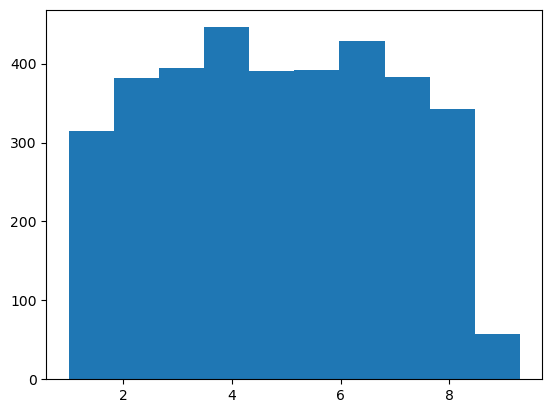

In [147]:
# Distribution of ratings
plt.hist(x='movie_rating', data=df)

In [148]:
df[['release_year', 'movie_duration','movie_rating']].corr()

,release_year,movie_duration,movie_rating
release_year,1.000000,-0.032880,-0.182967
movie_duration,-0.032880,1.000000,0.552251
movie_rating,-0.182967,0.552251,1.000000


### 4. Split Data

In [83]:
num_predictors = ['release_year', 'movie_duration']

In [84]:
X = pd.concat([df[num_predictors],X_text], axis=1) # combine with description df
y = df.movie_rating

In [85]:
X.head()

,release_year,movie_duration,desc_paig,desc_foster,desc_discov,desc_mysteri,desc_intrud,desc_insid,desc_artwork,desc_travel,...,desc_recur,desc_tur,desc_qualiti,desc_mimic,desc_moocher,desc_improvis,desc_guess,desc_gooni,desc_downstair,desc_ye
0,2023,61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010,83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023,117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1966,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011,85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2)

In [99]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2824, 8719) (707, 8719) (2824,) (707,)


### 5. Train and Evaluate Models

#### Lasso Regression

In [100]:
lasso_model = Lasso()

In [101]:
lasso_model.fit(X_train, y_train)

Lasso()

In [107]:
def display_metrics(y, preds):
    mse = metrics.mean_squared_error(y, preds)
    r2_score = metrics.r2_score(y, preds)
    rmse = np.sqrt(metrics.mean_squared_error(y, preds))
    print('MSE: {:.3f}'.format(mse))
    print('R squared error: {:.3f}'.format(r2_score))
    print('Root MSE {:.3f}'.format(rmse))

In [108]:
print('TRAIN')
train_preds = lasso_model.predict(X_train)
display_metrics(y_train, train_preds)

print('\nTEST')
test_preds = lasso_model.predict(X_test)
display_metrics(y_test, test_preds)

TRAIN
MSE: 2.936
R squared error: 0.345
Root MSE 1.714

TEST
MSE: 3.208
R squared error: 0.275
Root MSE 1.791


In [109]:
def plt_scatter(x, y, dataname):
    plt.scatter(x,y)
    plt.xlabel('Predicted ratings')
    plt.ylabel('Actual ratings')
    plt.title('Predicted vs Actual ratings of {} data'.format(dataname))

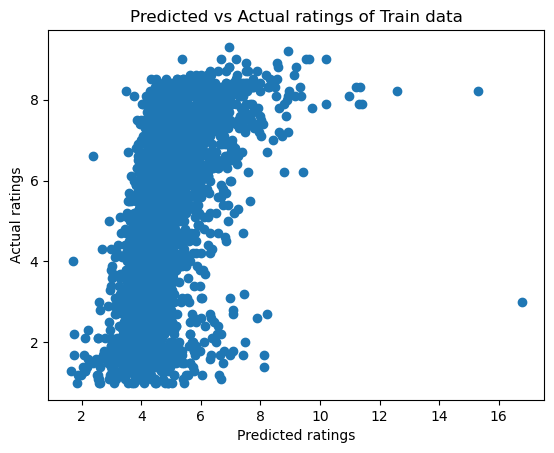

In [110]:
plt_scatter(train_preds, y_train, 'Train')

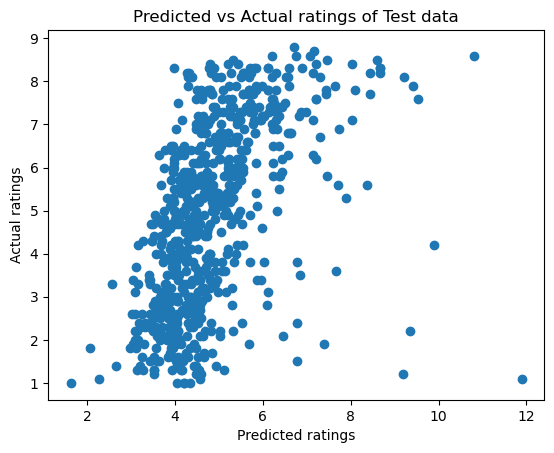

In [111]:
plt_scatter(test_preds, y_test, 'Test')

#### XGBoost Regressor

In [104]:
xgb_model = XGBRegressor()

In [105]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [106]:
print('TRAIN')
train_preds = xgb_model.predict(X_train)
display_metrics(y_train, train_preds)

print('\nTEST')
test_preds = xgb_model.predict(X_test)
display_metrics(y_test, test_preds)

TRAIN
MSE: 0.719
R squared error: 0.840
Root MSE 0.848

TEST
MSE: 2.683
R squared error: 0.394
Root MSE 1.638


- data suggests significant degree of overfitting
- RMSE suggests 1.638 rating error on average for the test set (similar to lasso)
- r2 score indicates that 39.4% of test variance is explained by model
- substantially larger mse than rmse in test model indicates possible outliers

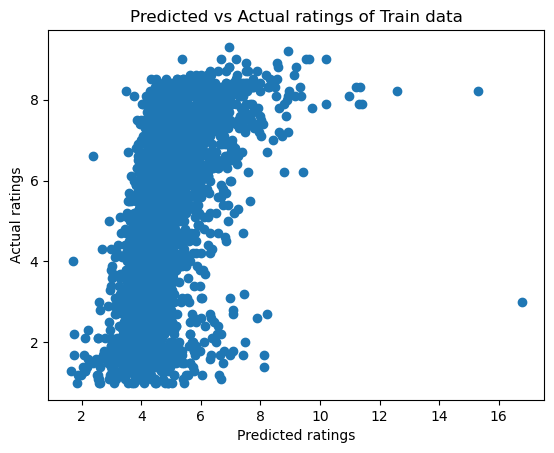

In [112]:
plt_scatter(train_preds, y_train, 'Train')

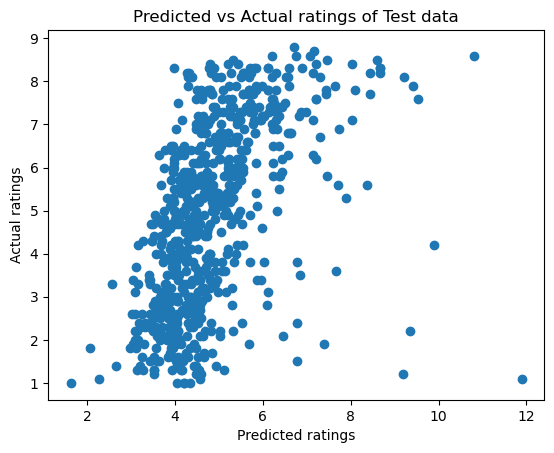

In [113]:
plt_scatter(test_preds, y_test, 'Test')